In [7]:
import sys
import os

# Add the root directory to sys.path
sys.path.append(os.path.abspath(".."))

Epoch 1/10, Loss: 0.346341, Test Loss: 0.005787
Epoch 2/10, Loss: 0.004247, Test Loss: 0.002073
Epoch 3/10, Loss: 0.001818, Test Loss: 0.001040
Epoch 4/10, Loss: 0.001153, Test Loss: 0.000677
Epoch 5/10, Loss: 0.000849, Test Loss: 0.000568
Epoch 6/10, Loss: 0.000390, Test Loss: 0.000112
Epoch 7/10, Loss: 0.000117, Test Loss: 0.000065
Epoch 8/10, Loss: 0.000072, Test Loss: 0.000042
Epoch 9/10, Loss: 0.000054, Test Loss: 0.000036
Epoch 10/10, Loss: 0.000050, Test Loss: 0.000035


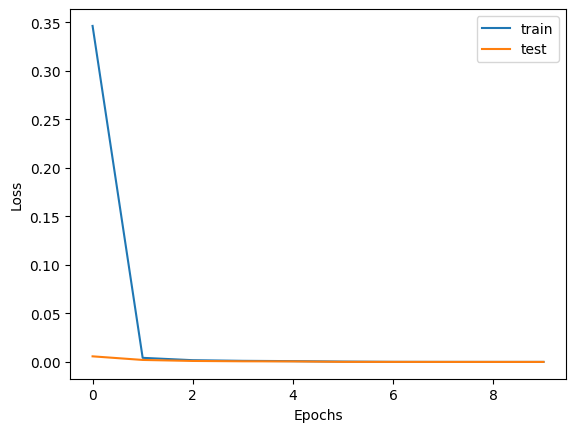

Model training completed successfully. Weights have been saved as 'baseline_model.pth' in the 'weights' directory.


In [ ]:
from dynamical_systems.mass_spring_damper_system import MassSpringDamperEnv
from models.feedforward_nn import FeedforwardNN
from random_exploration import random_exploration
from train import create_dataloader, train_model

import torch
import os

env = MassSpringDamperEnv(nlin=True)

# Hyperparameters
NUM_TRAJECTORIES = 100
HORIZON = 500
BATCH_SIZE = 50
NUM_EPOCHS = 10
LEARNING_RATE = 1e-3
HIDDEN_SIZE = 64

# Collect data from the environment
states, actions, next_states = random_exploration(env, NUM_TRAJECTORIES, HORIZON)
# Create DataLoader for training
train_dataloader = create_dataloader(states, actions, next_states, BATCH_SIZE)
# Collect data for test set
states, actions, next_states = random_exploration(env, 1, 500)
# Create DataLoader for training
test_dataloader = create_dataloader(states, actions, next_states, 500)

# Initialize the dynamics model
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
model = FeedforwardNN(state_dim, action_dim, hidden_size=HIDDEN_SIZE)

# Train the model
train_model(model, train_dataloader, test_dataloader, NUM_EPOCHS, LEARNING_RATE)

# Ensure the 'weights' directory exists
os.makedirs('../weights', exist_ok=True)

# Save the trained model
torch.save(model.state_dict(), '../weights/baseline_mass_spring_damper.pth')
print("Model training completed successfully. "
      "Weights have been saved as 'baseline_mass_spring_damper.pth' in the 'weights' directory.")

/tmp/ipykernel_86020/2603543325.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model.load_state_dict(torch.load('../weights/baseline_model.pth'))


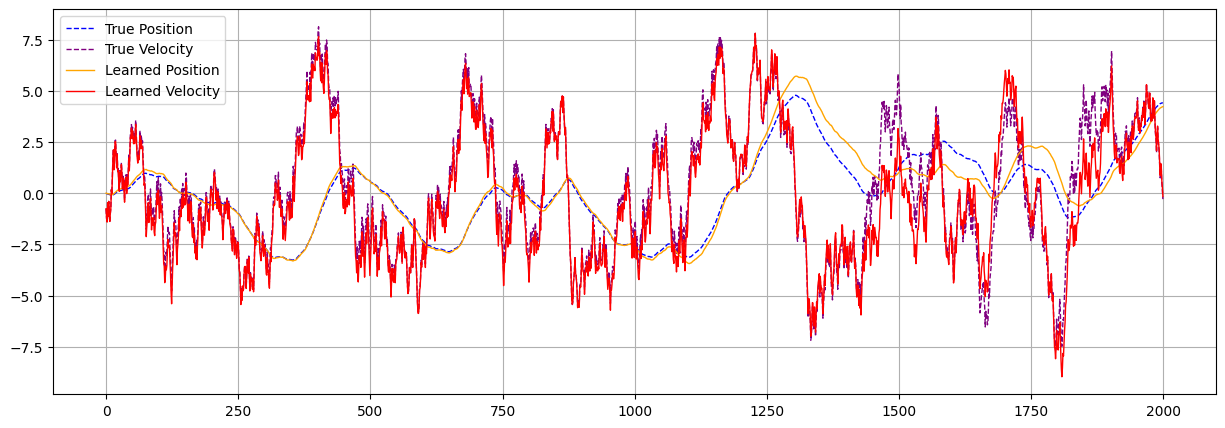

In [10]:
# test model
from dynamical_systems.mass_spring_damper_system import MassSpringDamperEnv

import numpy as np
import pygame
import matplotlib.pyplot as plt

# set random seed to get same test trajectory
test_seed = 44

# Using trained model as system dynamic
if __name__ == "__main__":
    # Initialize trained dynamics model
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    trained_model = FeedforwardNN(state_dim, action_dim, hidden_size=HIDDEN_SIZE)

    # load saved weights
    trained_model.load_state_dict(torch.load('../weights/baseline_model.pth'))
    trained_model.eval()

    # learned dynamic
    trained_env = MassSpringDamperEnv(model=trained_model)
    trained_env.reset()
    env.reset()
    env.action_space.seed(test_seed)
    env.action_space.seed(test_seed)
    save = [[],[]]
    # clock = pygame.time.Clock()
    for _ in range(2000):
        action = env.action_space.sample()
        obs, _, _, _, _= env.step(action)
        save[0].append(obs)
        obs, _, _, _, _= trained_env.step(action)
        save[1].append(obs)
        # clock.tick(400)
trained_env.close()

saved_traj = np.array(save)
plt.figure(1, (15,5))
plt.plot(saved_traj[0,:,0], label="True Position", color="blue", linestyle="--", linewidth=1)
plt.plot(saved_traj[0,:,1], label="True Velocity", color="purple", linestyle="--", linewidth=1)
plt.plot(saved_traj[1,:,0], label="Learned Position", color="orange", linewidth=1)
plt.plot(saved_traj[1,:,1], label="Learned Velocity", color="red", linewidth=1)
plt.legend()
plt.grid(True)
plt.show()

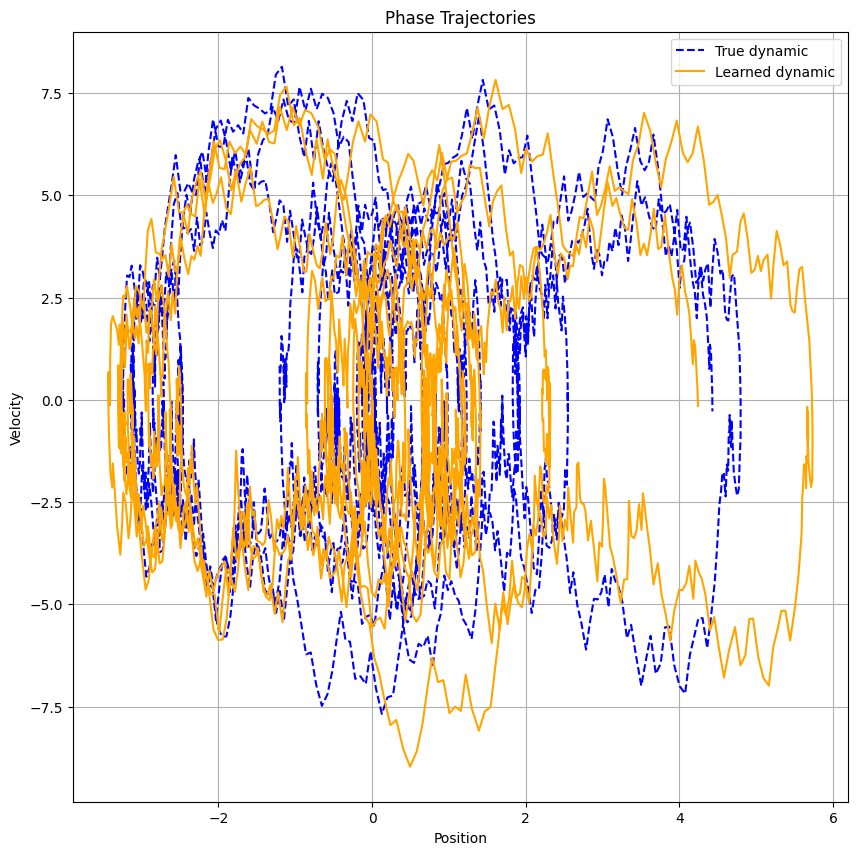

In [11]:
# Plot Phase Trajectories (Position vs Velocity)
plt.figure(2, (10, 10))
plt.plot(saved_traj[0,:,0], saved_traj[0,:,1], label="True dynamic", color="blue", linestyle="--")
plt.plot(saved_traj[1,:,0], saved_traj[1,:,1], label="Learned dynamic", color="orange")
plt.legend()
plt.grid(True)
plt.title("Phase Trajectories")
plt.xlabel("Position")
plt.ylabel("Velocity")
plt.show()